<a href="https://colab.research.google.com/github/Ron-po/cardiovascular-sensing/blob/main/Deconvolving_cordiovascular_signal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpyro jax jaxlib
!pip install vitaldb
!wget -q https://github.com/google/fonts/raw/main/apache/opensans/OpenSans-Regular.ttf -O OpenSans-Regular.ttf

!mkdir -p ~/.fonts
!mv OpenSans-Regular.ttf ~/.fonts/

In [2]:
# We assume that the signal we recieve is Y = Z * X (convolution)


# ECG
# Find reasonably good z's
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import butter, filtfilt, find_peaks, resample
from sklearn.decomposition import PCA

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from vitaldb import VitalFile, find_cases

#  BUILD PRIOR ON z′ FROM ECG-ONLY RECORDS
print("0) Learning prior on z' from ECG…")
ecg_caseids = find_cases(['ECG_II'])
MAX_CASES   = 200
MAX_DIM     = 10

fs = 100
all_z = []
for cid in ecg_caseids[:MAX_CASES]:
    vf = VitalFile(cid, ['ECG_II'])
    ecg = vf.to_numpy(['ECG_II'], 1/fs)[:,0]
    # take a long window in the middle
    N = len(ecg)
    seg = ecg[N//4: N//4 + 30*fs]  # 30s chunk
    peaks, _ = find_peaks(seg, prominence=0.7, distance=fs*0.4)
    if len(peaks) < MAX_DIM+1:
        continue
    z = np.diff(peaks[:MAX_DIM+1]) / fs
    if z.mean()<0.3 or z.mean()>2.0:
        continue
    all_z.append(z)
    if len(all_z)>=100:  # enough subjects
        break

samples_z = np.vstack(all_z)[:,:MAX_DIM]  # (S, D)
mean_z = samples_z.mean(0)
cov_z  = np.cov(    samples_z, rowvar=False)

print(f"Got {samples_z.shape[0]} samples of dimension {samples_z.shape[1]}")

0) Learning prior on z' from ECG…
Got 100 samples of dimension 10


Covariance matrix of inter-beat intervals (z'):


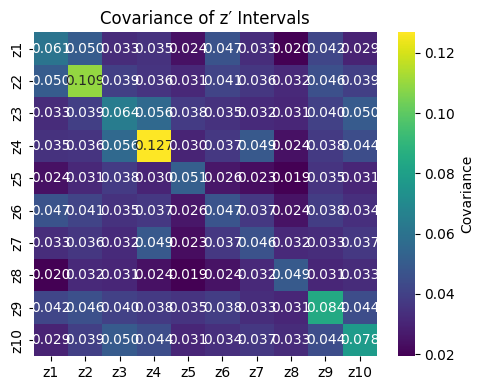

In [3]:
import pandas as pd
#Covariance matrix
cov_z  = np.cov(samples_z, rowvar=False)

# print out the covariance matrix
print("Covariance matrix of inter-beat intervals (z'):")
df_cov = pd.DataFrame(
    cov_z,
    columns=[f"z{i+1}" for i in range(cov_z.shape[1])],
    index=[f"z{i+1}" for i in range(cov_z.shape[1])]
)
plt.figure(figsize=(5,4))
sns.heatmap(df_cov, annot=True, fmt=".3f", cmap="viridis",
            cbar_kws={"label":"Covariance"})
plt.title("Covariance of z′ Intervals")
plt.tight_layout()
plt.show()


In [4]:
#reasonably good PPG
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks
from vitaldb import VitalFile, find_cases

# Parameters
fs = 100              # PPG sampling rate (Hz)
MAX_CASES = 300       # target number of good PPG cases
WINDOW_S = 30         # length of segment to test (seconds)
STD_THRESH = 0.01     # minimum PPG segment std dev (reject flat)
PROMINENCE = 0.5      # peak detection prominence
MIN_PEAKS = 20        # at least this many beats in WINDOW_S
RR_MEAN_MIN = 0.1     # min plausible RR interval (s) => max 150 bpm
RR_MEAN_MAX = 3     # max plausible RR interval (s) => min 40 bpm
RR_STD_MAX  = 0.1     # max RR variability (s)

def bandpass(x, fs, low=0.5, high=8.0, order=4):
    b, a = butter(order, [low/(fs/2), high/(fs/2)], btype='band')
    return filtfilt(b, a, x)

good_caseids = []
ppg_segments  = []

# find all cases with PPG
ppg_caseids = find_cases(['PLETH'])

for cid in ppg_caseids:
    if len(good_caseids) >= MAX_CASES:
        break

    # load a WINDOW_S-second chunk from middle of record
    vf = VitalFile(cid, ['PLETH'])
    ppg = vf.to_numpy(['PLETH'], 1/fs)[:,0]
    N = len(ppg)
    start = N//2 - WINDOW_S*fs//2
    end   = start + WINDOW_S*fs
    if start < 0 or end > N:
        continue
    seg = ppg[start:end]

    # Check if it is flat
    if np.std(seg) < STD_THRESH:
        continue

    # bandpass filter
    seg_f = bandpass(seg, fs)

    # Valid number of PPG peaks
    peaks, props = find_peaks(seg_f,
        prominence=PROMINENCE,
        distance=fs*0.4
    )

    #Do not add if nto enough
    if len(peaks) < MIN_PEAKS:
        continue

    # compute RR intervals in seconds
    rr = np.diff(peaks) / fs
    if not (RR_MEAN_MIN <= rr.mean() <= RR_MEAN_MAX):
        continue
    if rr.std() > RR_STD_MAX:
        continue

    # passed all checks
    good_caseids.append(cid)
    ppg_segments.append(seg_f)  # or store raw seg if preferred

print(f"Collected {len(good_caseids)} good PPG cases (out of {len(ppg_caseids)})")




Collected 300 good PPG cases (out of 6157)


Case 1 has 1154110 samples (11541.1 s at 100 Hz)
First 10 samples: [nan nan nan nan nan nan nan nan nan nan]
Last 10 samples:  [  0.426   -5.8938  12.2754  -3.9189  -1.549    6.3507 -10.2386  13.0654
  -4.3138  -5.8938]


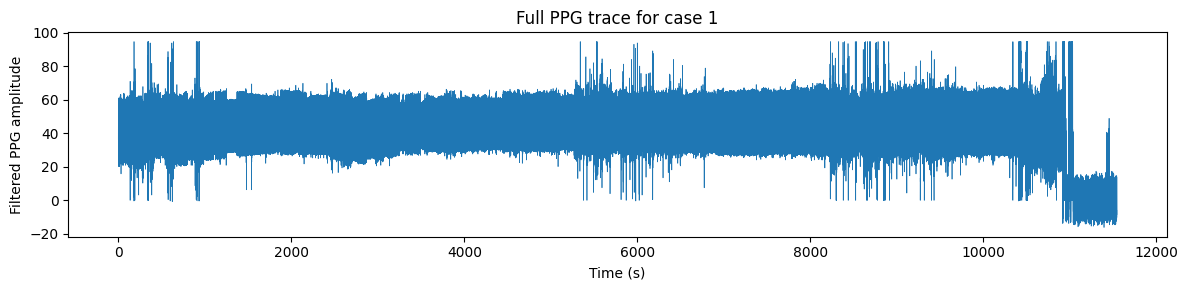

In [5]:
#Show how a single case looks like


# Pick one case (e.g. the first valid one you found)
example_cid = good_caseids[0]

# Load the full PPG for that case
vf_full = VitalFile(example_cid, ['PLETH'])
# returns an (N×1) array of samples; N = total_samples = duration_in_seconds * fs
ppg_full = vf_full.to_numpy(['PLETH'], 1/fs)[:,0]

# Print out its size so you know how long it is
print(f"Case {example_cid} has {ppg_full.shape[0]} samples ({ppg_full.shape[0]/fs:.1f} s at {fs} Hz)")

# Peek at the start/end values
print("First 10 samples:", np.round(ppg_full[:10],4))
print("Last 10 samples: ", np.round(ppg_full[-10:],4))

# And (optionally) plot the whole thing to see its overall shape
t_full = np.arange(ppg_full.shape[0]) / fs
plt.figure(figsize=(12,3))
plt.plot(t_full, ppg_full, linewidth=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Filtered PPG amplitude")
plt.title(f"Full PPG trace for case {example_cid}")
plt.tight_layout()
plt.show()


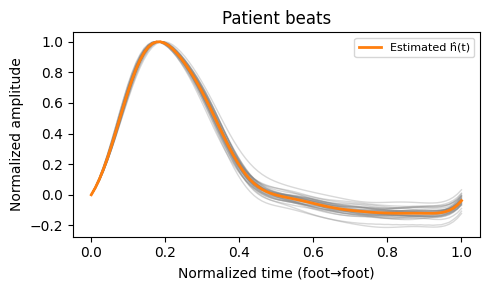

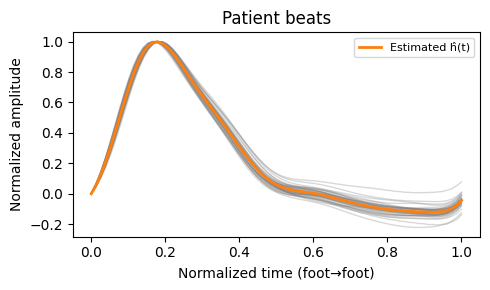

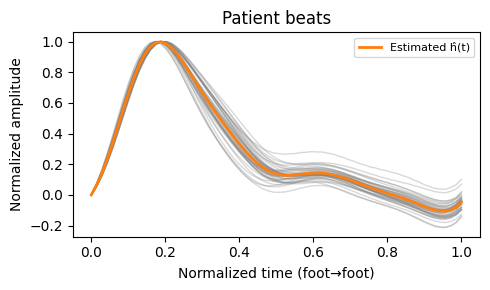

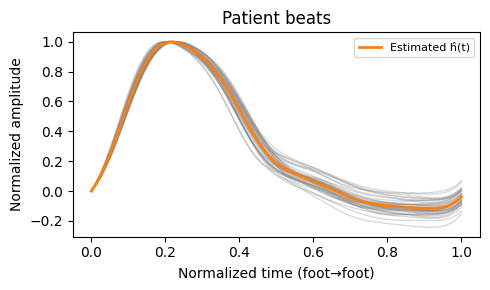

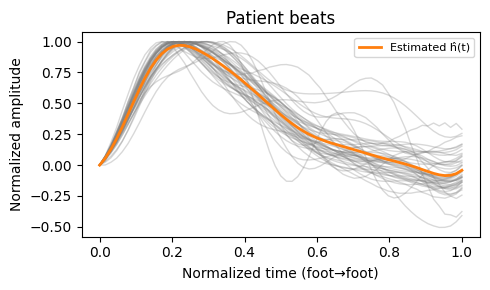

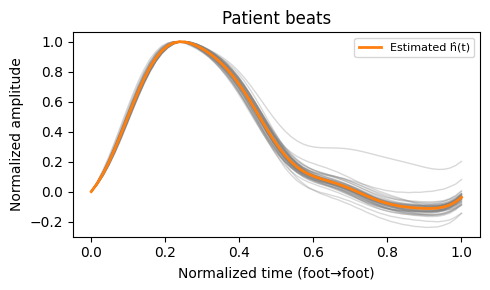

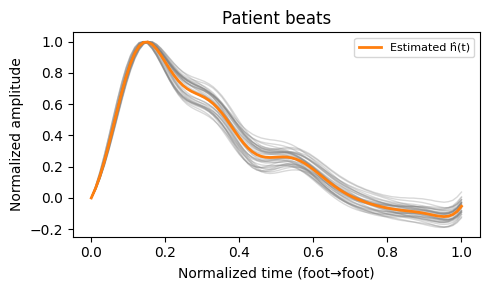

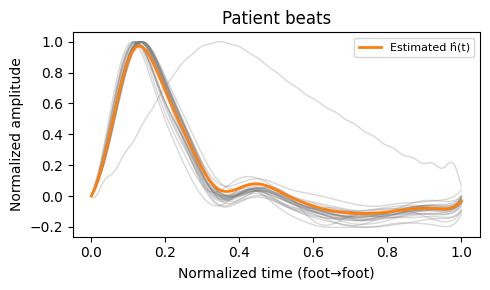

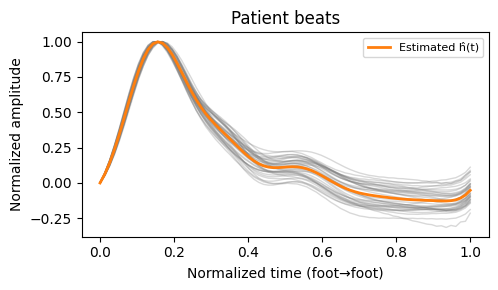

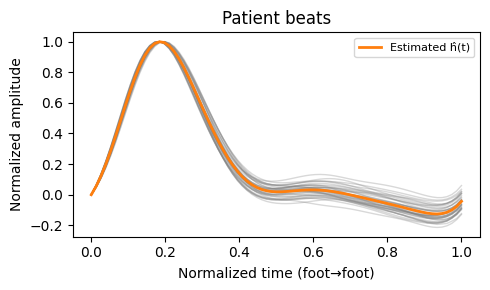

In [21]:
# ECG
# Find reasonably good z's
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import butter, filtfilt, find_peaks, resample
from sklearn.decomposition import PCA

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from vitaldb import VitalFile, find_cases
def detect_foot(seg):
    d = np.diff(seg, prepend=seg[0])
    i_max = np.argmax(d)
    m, y0 = d[i_max], seg[i_max]
    if m <= 0:
        return 0
    b = y0 - m*i_max
    baseline = np.min(seg[:i_max+1])
    x0 = (baseline - b)/m
    return int(np.clip(round(x0), 0, len(seg)-1))
# collect templates
h_templates   = []
cids_for_pca  = []

num_plots = 0

for cid, seg_f in zip(good_caseids, ppg_segments):
    # Find simple peaks
    peaks, _ = find_peaks(seg_f, prominence=PROMINENCE, distance=fs*0.4)
    if len(peaks) < 2:
        continue

    # Locate feet between each pair of consecutive peaks and store location in array
    feet = []
    for i in range(len(peaks)-1):
        a, b = peaks[i], peaks[i+1]
        sub = seg_f[a:b]
        if len(sub)<5:
            continue
        feet.append(a + detect_foot(sub))
    if len(feet)<2:
        continue

    # Extract foot to foot Signal, resample & normalize
    L = int(np.median(np.diff(feet)))
    pulses = []
    for i in range(len(feet)-1):
        a, b = feet[i], feet[i+1]
        beat = seg_f[a:b]
        beat_rs = resample(beat, L)
        beat_rs -= beat_rs[0]
        pk = beat_rs.max()
        if pk>0:
            pulses.append(beat_rs/pk)  # normalize peaks to be 1
    if not pulses:
        continue
    pulses = np.vstack(pulses)

    # Average template
    h_hat = pulses.mean(axis=0)

    # collect for PCA later
    h_templates.append(h_hat)
    cids_for_pca.append(cid)

    # Plot 10 cases for visualization before moving on

    if num_plots < 10:
        t = np.linspace(0, 1, h_hat.size)
        plt.figure(figsize=(5, 3))
        for p in pulses:
            plt.plot(t, p, color='gray', alpha=0.3, lw=1)
        plt.plot(t, h_hat, color='C1', lw=2, label='Estimated ĥ(t)')
        plt.title(f"Patient beats")
        plt.xlabel("Normalized time (foot→foot)")
        plt.ylabel("Normalized amplitude")
        plt.legend(fontsize=8)
        plt.tight_layout()
        plt.show()
        num_plots += 1

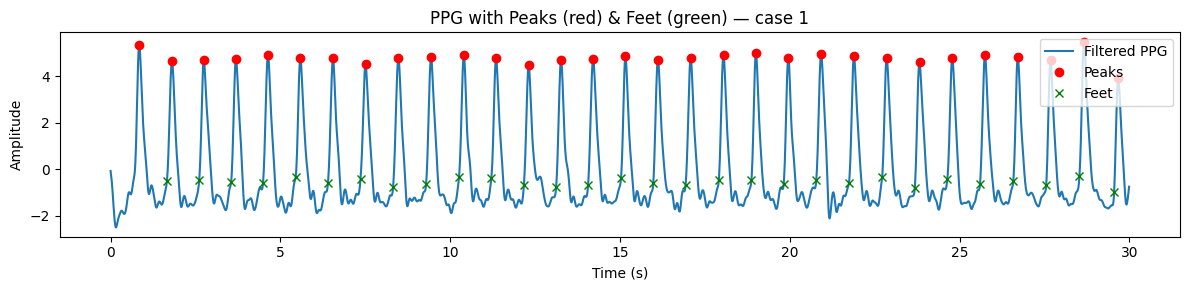

In [7]:
#Plot

t = np.arange(len(seg_f)) / fs  # time in seconds

plt.figure(figsize=(12, 3))
plt.plot(t, seg_f,            label="Filtered PPG")
plt.plot(peaks/fs, seg_f[peaks], 'ro', label="Peaks")
plt.plot(np.array(feet)/fs, seg_f[feet], 'gx', label="Feet")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title(f"PPG with Peaks (red) & Feet (green) — case {good_caseids[0]}")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [8]:
h_templates = np.vstack([resample(h, L) for h in h_templates])

# Run PCA
pca = PCA()
pca.fit(h_templates)
mean_pulse = pca.mean_           # (L0,)
pcs        = pca.components_     # (n_modes, L0)
eigs       = pca.explained_variance_
cumvar     = np.cumsum(pca.explained_variance_ratio_)
K = np.searchsorted(cumvar, 0.95) + 1
print(f"Keeping K={K} ({cumvar[K-1]*100:.1f}% var)")

Keeping K=4 (95.6% var)


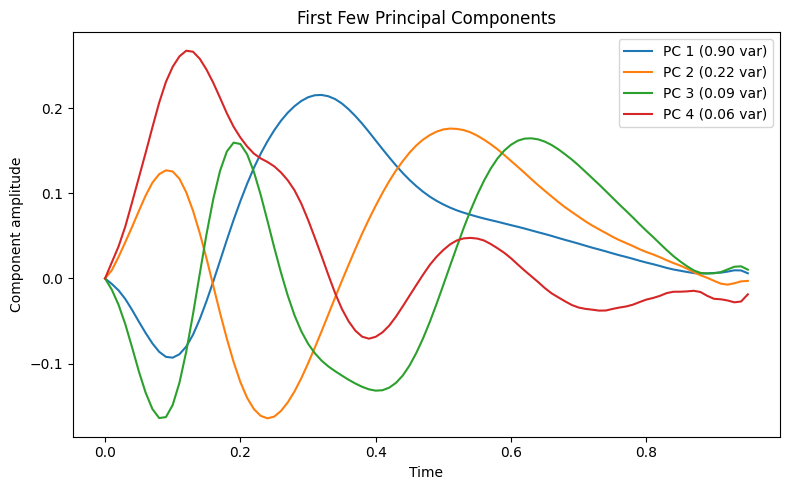


PC 1 polynomial (deg 10):
  x^10 * -9.834e+02
  x^ 9 * 6.938e+03
  x^ 8 * -2.015e+04
  x^ 7 * 3.183e+04
  x^ 6 * -3.003e+04
  x^ 5 * 1.733e+04
  x^ 4 * -5.951e+03
  x^ 3 * 1.106e+03
  x^ 2 * -8.668e+01
  x^ 1 * 1.247e+00
  x^ 0 * -6.179e-03

PC 2 polynomial (deg 10):
  x^10 * 9.505e+03
  x^ 9 * -4.965e+04
  x^ 8 * 1.118e+05
  x^ 7 * -1.412e+05
  x^ 6 * 1.092e+05
  x^ 5 * -5.262e+04
  x^ 4 * 1.532e+04
  x^ 3 * -2.456e+03
  x^ 2 * 1.732e+02
  x^ 1 * -2.671e+00
  x^ 0 * 1.293e-02

PC 3 polynomial (deg 10):
  x^10 * -2.010e+04
  x^ 9 * 1.011e+05
  x^ 8 * -2.171e+05
  x^ 7 * 2.584e+05
  x^ 6 * -1.852e+05
  x^ 5 * 8.098e+04
  x^ 4 * -2.079e+04
  x^ 3 * 2.799e+03
  x^ 2 * -1.448e+02
  x^ 1 * -4.673e-01
  x^ 0 * 1.246e-02

PC 4 polynomial (deg 10):
  x^10 * 5.145e+03
  x^ 9 * -2.154e+04
  x^ 8 * 3.767e+04
  x^ 7 * -3.615e+04
  x^ 6 * 2.133e+04
  x^ 5 * -8.387e+03
  x^ 4 * 2.301e+03
  x^ 3 * -3.963e+02
  x^ 2 * 2.251e+01
  x^ 1 * 2.473e+00
  x^ 0 * -1.182e-02

PC 1 expoential fit: a=0.065, tau

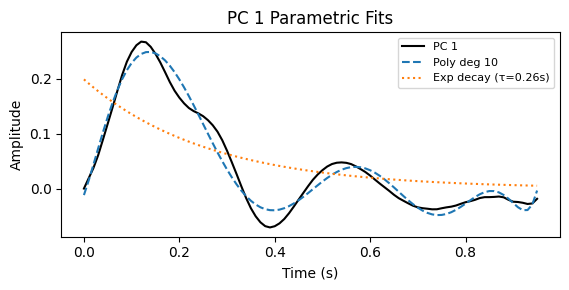

In [9]:
#Discrete
from scipy.optimize import curve_fit

# Visualize the first few PCs

n_show = 4
t_pc   = np.arange(pcs.shape[1]) / fs   # time axis for one pulse

plt.figure(figsize=(8,5))
for i in range(n_show):
    plt.plot(t_pc, pcs[i], label=f'PC {i+1} ({eigs[i]:.2f} var)')
plt.xlabel("Time")
plt.ylabel("Component amplitude")
plt.title("First Few Principal Components")
plt.legend()
plt.tight_layout()
plt.show()


# Try to fit Polynomial of some degree
deg = 10
poly_coefs = []
for i in range(n_show):
    coefs = np.polyfit(t_pc, pcs[i], deg)
    poly_coefs.append(coefs)

# print polynomial coefficients
for i, coefs in enumerate(poly_coefs):
    print(f"\nPC {i+1} polynomial (deg {deg}):")
    for j, c in enumerate(coefs):
        print(f"  x^{deg-j:>2} * {c:.3e}")

# Try to fit Exponential  a * exp(-t / tau):  wehre alpha is the 'height' of exp (at the beginning)
# and tau is hwo quickly it decays.
def exp_decay(t, a, tau):
    return a * np.exp(-t / tau)

exp_params = []
for i in range(n_show):
    # initial guesses: a=pcs[i,0] just assign tha highest point of the PC
    # tau=average of the duration: not too long and not too short
    p0 = [pcs[i].max(), (L-1)/(2*fs)] #take the average time
    try:
        popt, _ = curve_fit(exp_decay, t_pc, pcs[i], p0=p0)
    except RuntimeError:
        popt = [np.nan, np.nan]
    exp_params.append(popt)

# print exponential fit params (alpha and tau)
for i, (a, tau) in enumerate(exp_params):
    print(f"\nPC {i+1} expoential fit: a={a:.3f}, tau={tau:.3f} s")

# Overlay fits for the first PC as example
i = 3
plt.figure(figsize=(6,3))
plt.plot(t_pc, pcs[i], 'k-', label='PC 1')
# polynomial curve
poly_curve = np.polyval(poly_coefs[i], t_pc)
plt.plot(t_pc, poly_curve, '--', label=f'Poly deg {deg}')

# exponential curve      APPEARS FLAT (maybe need to add constrain to tau?)
a, tau = exp_params[i]
plt.plot(t_pc, exp_decay(t_pc, a, tau), ':', label=f'Exp decay (τ={tau:.2f}s)')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("PC 1 Parametric Fits")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

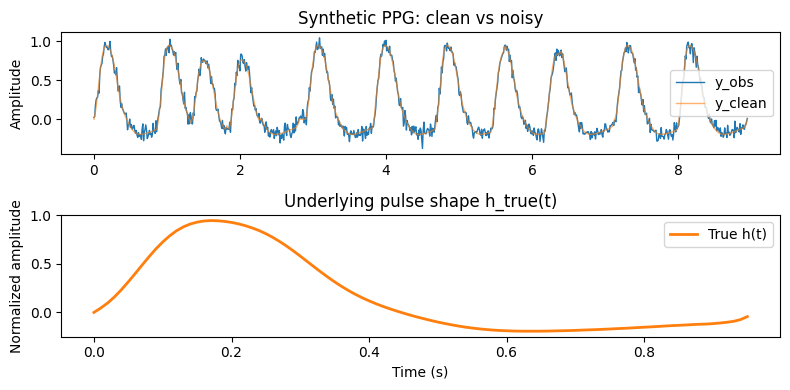

In [10]:
# Build a synthetic test y_obs
D    = mean_z.shape[0]       # number of intervals
L0   = mean_pulse.shape[0]   # length of each pulse template - Basically just the L from before

# Sample true h from your PCA prior
w_true = np.random.normal(0, np.sqrt(eigs[:K]))    #  drawing a length K vector of independent Gaussian weights, one weight
                                                   #  for each Primcipla Comp.
h_true = mean_pulse + w_true @ pcs[:K]             # truct from sampled PCAs

# Sample true intervals z_true
z_true = np.random.multivariate_normal(mean_z, cov_z)  # (D,)
t_beats = np.concatenate([[0.0], np.cumsum(z_true)])   # (D+1,) get pulses in seconds

#  Build the clean convolution
t_max = t_beats[-1] + L0/fs
t_obs = np.arange(0, t_max, 1/fs)                   # time axis for y
imp    = np.zeros_like(t_obs)
idx    = (t_beats * fs).astype(int)
imp[idx] = 1.0

# create y_clean by convolving h_true with the pulses we created with z'
y_clean = np.convolve(imp, h_true, mode="full")[:t_obs.size]

#  Add noise
noise_sigma = 0.05

#final synthetic signal
y_obs = y_clean + np.random.normal(0, noise_sigma, size=y_clean.shape)

# Plot synthetic y and h_true
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,4), sharex=False)

# top: observed + clean
ax1.plot(t_obs, y_obs,    label="y_obs",   lw=1)
ax1.plot(t_obs, y_clean,  label="y_clean", lw=1, alpha=0.6)
ax1.set_ylabel("Amplitude")
ax1.set_title("Synthetic PPG: clean vs noisy")
ax1.legend()

# bottom: the ground‐truth pulse shape
t_h = np.arange(L0) / fs
ax2.plot(t_h, h_true, color="C1", lw=2, label="True h(t)")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Normalized amplitude")
ax2.set_title("Underlying pulse shape h_true(t)")
ax2.legend()

plt.tight_layout()
plt.show()


Running MCMC on synthetic data…


sample: 100%|██████████| 3000/3000 [06:52<00:00,  7.28it/s, 1023 steps of size 4.72e-06. acc. prob=0.97]


Done sampling.


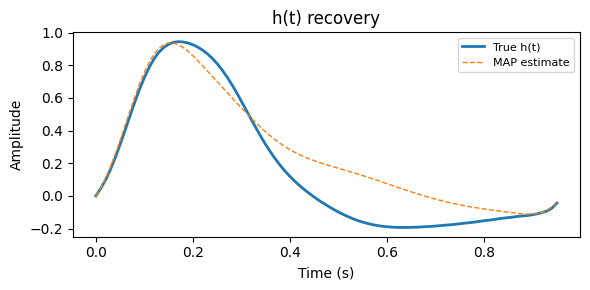

RMSE (MAP) : 0.1478


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks, resample
import jax, jax.numpy as jnp
import jax.lax as lax
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.infer.initialization import init_to_median
from sklearn.decomposition import PCA
def pulse_model(t, y_obs=None):
    # PCA weights
    w = numpyro.sample("w",
        dist.Normal(0, jnp.sqrt(eigs[:K])).expand([K]).to_event(1)
    )
    # interval prior
    z = numpyro.sample("z",
        dist.MultivariateNormal(jnp.array(mean_z), jnp.array(cov_z))
    )
    # reconstruct h
    h = mean_pulse + jnp.dot(w, jnp.array(pcs[:K]))   # (L0,)
    # prepare arrays for conv
    imp = jnp.zeros_like(t)
    T   = jnp.cumsum(z)
    idx = (T * fs).astype(int)
    imp = imp.at[idx].set(1.0)
    # conv via lax.conv_general_dilated
    # reshape to (N=1, C=1, W)
    imp3 = imp[None, None, :]
    # kernel must be (out_chan=1, in_chan=1, K)
    kernel = h[::-1][None, None, :]
    # full convolution pad=(L0-1, L0-1)
    y3 = lax.conv_general_dilated(
        imp3, kernel,
        window_strides=(1,),
        padding=[(L0-1, L0-1)]
    )  # shape (1,1, T_obs+L0-1)
    y_hat = y3[0,0,: t.shape[0]]
    # noise + likelihood
    sigma = numpyro.sample("sigma", dist.HalfNormal(0.1))
    numpyro.sample("y", dist.Normal(y_hat, sigma), obs=y_obs)

# 7) Run NUTS
kernel = NUTS(pulse_model, init_strategy=init_to_median())
mcmc   = MCMC(kernel, num_warmup=1000, num_samples=2000)
rng    = jax.random.PRNGKey(0)
print("Running MCMC on synthetic data…")
mcmc.run(rng, t=jnp.array(t_obs), y_obs=jnp.array(y_obs))
posterior = mcmc.get_samples()
print("Done sampling.")

# 8) Posterior summaries
W_samps   = np.array(posterior['w'])
Z_samps   = np.array(posterior['z'])
sig_samps = np.array(posterior['sigma'])
S = W_samps.shape[0]

# posterior mean h
h_mean = mean_pulse + W_samps.mean(0) @ pcs[:K]

# MAP via brute LL
ll = np.empty(S)
for i in range(S):
    hi = mean_pulse + W_samps[i] @ pcs[:K]
    T_i = np.cumsum(Z_samps[i]) * fs
    y_hat = np.zeros_like(y_obs)
    for t0 in T_i.astype(int):
        if t0 + L0 <= len(y_obs):
            y_hat[t0:t0+L0] += hi
    res = (y_obs - y_hat) / sig_samps[i]
    ll[i] = -0.5 * np.sum(res**2 + np.log(2*np.pi*sig_samps[i]**2))
map_idx = ll.argmax()
h_map = mean_pulse + W_samps[map_idx] @ pcs[:K]

# 9) Plot & RMSE
t_h = np.arange(L0)/fs
plt.figure(figsize=(6,3))
plt.plot(t_h, h_true, label="True h(t)",    lw=2)
plt.plot(t_h, h_map,  label="MAP estimate",  lw=1, ls="--")
plt.legend(fontsize=8); plt.xlabel("Time (s)")
plt.ylabel("Amplitude"); plt.title("h(t) recovery")
plt.tight_layout(); plt.show()

rmse_mean = np.sqrt(np.mean((h_mean-h_true)**2))
rmse_map  = np.sqrt(np.mean((h_map-h_true)**2))
print(f"RMSE (MAP) : {rmse_map:.4f}")


PC1 definition:
PC1: [t<0] p(0)e^(t/τ_ext), [0≤t≤T] -9.83e+02·t^10 + 6.94e+03·t^9 + -2.02e+04·t^8 + 3.18e+04·t^7 + -3.00e+04·t^6 + 1.73e+04·t^5 + -5.95e+03·t^4 + 1.11e+03·t^3 + -8.67e+01·t^2 + 1.25e+00·t^1 + -6.18e-03·t^0, [t>T] p(T)e^(-(t-T)/τ_ext)

PC2 definition:
PC2: [t<0] p(0)e^(t/τ_ext), [0≤t≤T] 9.51e+03·t^10 + -4.97e+04·t^9 + 1.12e+05·t^8 + -1.41e+05·t^7 + 1.09e+05·t^6 + -5.26e+04·t^5 + 1.53e+04·t^4 + -2.46e+03·t^3 + 1.73e+02·t^2 + -2.67e+00·t^1 + 1.29e-02·t^0, [t>T] p(T)e^(-(t-T)/τ_ext)

PC3 definition:
PC3: [t<0] p(0)e^(t/τ_ext), [0≤t≤T] -2.01e+04·t^10 + 1.01e+05·t^9 + -2.17e+05·t^8 + 2.58e+05·t^7 + -1.85e+05·t^6 + 8.10e+04·t^5 + -2.08e+04·t^4 + 2.80e+03·t^3 + -1.45e+02·t^2 + -4.67e-01·t^1 + 1.25e-02·t^0, [t>T] p(T)e^(-(t-T)/τ_ext)

PC4 definition:
PC4: [t<0] p(0)e^(t/τ_ext), [0≤t≤T] 5.15e+03·t^10 + -2.15e+04·t^9 + 3.77e+04·t^8 + -3.62e+04·t^7 + 2.13e+04·t^6 + -8.39e+03·t^5 + 2.30e+03·t^4 + -3.96e+02·t^3 + 2.25e+01·t^2 + 2.47e+00·t^1 + -1.18e-02·t^0, [t>T] p(T)e^(-(t-T)/τ_ext

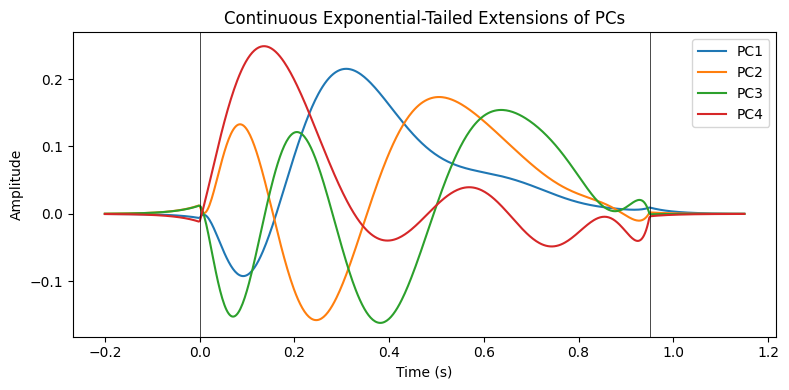

In [12]:
n_show = 4
T       = t_pc[-1]    #
tau_ext = 0.05        # tail decay rate

def make_extended_func(coefs, T, tau_ext, doc=None):
    """
    Returns a continuous piecewise function h(t):

      for t<0:    h(t) = p(0) * exp(t/tau_ext)
      for 0≤t≤T:  h(t) = p(t)
      for t>T:    h(t) = p(T) * exp(-(t-T)/tau_ext)

    where p(t) = np.polyval(coefs, t).
    """
    def func(t):
        t = np.asarray(t)
        # core polynomial on [0, T]
        y = np.polyval(coefs, np.clip(t, 0, T))

        # left exponential tail for t < 0 with y0 as the leftmost point in domain(t = 0)
        mask = t < 0
        if mask.any():
            y0    = np.polyval(coefs, 0)
            y[mask] = y0 * np.exp(   t[mask]   / tau_ext)
        # right exponential tail for t < 0 with y0 as the leftmost point in domain(t = T)
        mask = t > T
        if mask.any():
            yT    = np.polyval(coefs, T)
            y[mask] = yT * np.exp(-(t[mask]-T)/tau_ext)
        return y

    # need to add in order to actually print(h())?????
    if doc is not None:
        func.__doc__ = doc
    return func

lines = []
for i in range(n_show):
    coefs = poly_coefs[i]
    poly_terms = " + ".join(f"{coefs[j]:.2e}·t^{deg-j}"
                            for j in range(len(coefs)))
    lines.append(
        f"PC{i+1}: [t<0] p(0)e^(t/τ_ext), "
        f"[0≤t≤T] {poly_terms}, "
        f"[t>T] p(T)e^(-(t-T)/τ_ext)"
    )

ext_functions = []
for k in range(n_show):
    # lines[k] is the piecewise‐formula for PC k+1
    f = make_extended_func(poly_coefs[k], T, tau_ext, doc=lines[k])
    ext_functions.append(f)

# Print each function's docstring
for idx, h in enumerate(ext_functions, start=1):
    print(f"\nPC{idx} definition:\n{h.__doc__}")

# Plot them to verify

t_ext = np.linspace(-0.2, T + 0.2, 600)
plt.figure(figsize=(8,4))
for idx, h in enumerate(ext_functions, start=1):
    plt.plot(t_ext, h(t_ext), label=f'PC{idx}')
plt.axvline(0, color='k', lw=0.5)
plt.axvline(T, color='k', lw=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Continuous Exponential-Tailed Extensions of PCs")
plt.legend()
plt.tight_layout()
plt.show()

first 10 y_obs samples: [-0.0166454   0.02655838  0.06794246  0.21662028  0.25972409  0.45742098
  0.46117112  0.54911585  0.57026542  0.67879465]
last 10 y_obs samples: [-0.06168449 -0.00811445  0.01834012  0.04172127  0.06006709 -0.05368013
  0.03776184 -0.02652986  0.00639064  0.05041074]


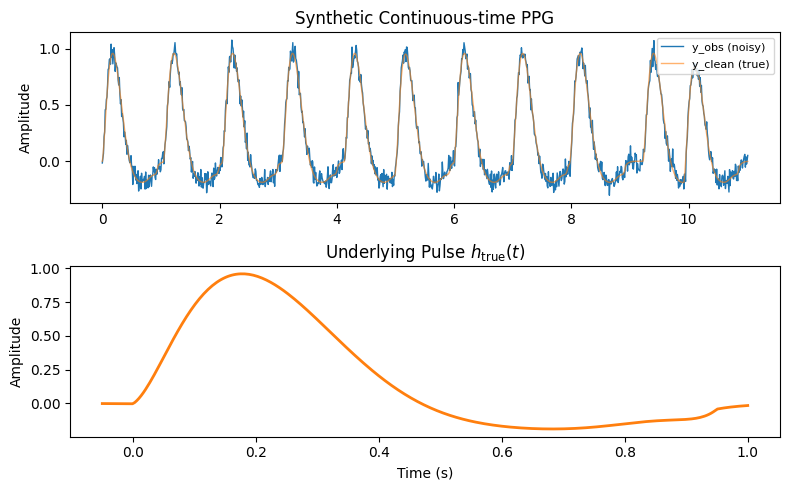

In [13]:

# Continuous Y_obs

# Build continuous mean pulse h̄(t) from PCA, then when construct -> mean wave plus weights.
#degree of poly to fit
deg_mean   = poly_coefs[0].shape[0] - 1
# get poly of mean 'wave' of PC.
coefs_mean = np.polyfit(t_pc, mean_pulse, deg_mean)
mean_ext   = make_extended_func(coefs_mean, T, tau_ext,
                                doc="extended mean pulse with exp-tails")

K           = len(ext_functions)
w_true      = np.random.normal(0, np.sqrt(eigs[:K]), size=K)
z_intervals = np.random.multivariate_normal(mean_z, cov_z)   # sample beat to beat intervals
t_beats     = np.concatenate([[0.0], np.cumsum(z_intervals)])# beat times (s)


def h_base(t):
    """t can also be array"""
    t = np.asarray(t, dtype=float)
    y = mean_ext(t)
    for k in range(K):
        y += w_true[k] * ext_functions[k](t) # the kth principal component shape times its weight added to mean wave of PCA
    return y

# Continuous noisy y as a callable function
noise_sigma = 0.05
def y_obs_func(t):
    """
    Continuous y_obs(t) = Σ_i h_base(t − z_i) + Noise(t),
    where Noise(t) ~ Normal(0, noise_sigma^2) drawn independently at each t.
    """
    t = np.asarray(t, dtype=float)
    y = np.zeros_like(t)
    for zi in t_beats:
        y += h_base(t - zi)
    # add Gaussian noise at each requested t
    y += np.random.normal(0, noise_sigma, size=t.shape)
    return y

# Sample on a 100 Hz grid for inference/plotting
t_max = t_beats[-1] + T + 3*tau_ext
t_obs = np.arange(0, t_max, 1/fs)

# draw the noisy samples
y_obs   = y_obs_func(t_obs)

# derive the y_clean
y_clean = np.zeros_like(t_obs)
for zi in t_beats:
    y_clean += h_base(t_obs - zi)

print("first 10 y_obs samples:", y_obs[:10])
print("last 10 y_obs samples:", y_obs[-10:])

# Plot noisy and clean
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,5))


ax1.plot(t_obs, y_obs,   lw=1, label="y_obs (noisy)")
ax1.plot(t_obs, y_clean, lw=1, alpha=0.6, label="y_clean (true)")
ax1.set(title="Synthetic Continuous-time PPG", ylabel="Amplitude")
ax1.legend(fontsize=8)


t_ref = np.linspace(-tau_ext, T + tau_ext, 300)
ax2.plot(t_ref, h_base(t_ref), color="C1", lw=2)
ax2.set(title="Underlying Pulse $h_{\\mathrm{true}}(t)$",
        xlabel="Time (s)", ylabel="Amplitude")

plt.tight_layout()
plt.show()


Running continuous‐time MCMC…


sample: 100%|██████████| 3000/3000 [01:32<00:00, 32.27it/s, 63 steps of size 7.23e-02. acc. prob=0.93]


Done sampling.



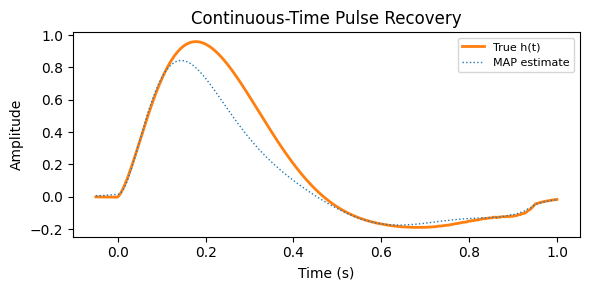

In [14]:
# Continuous MCMC
import jax, jax.numpy as jnp
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.infer.initialization import init_to_feasible
import matplotlib.pyplot as plt

#JAX‐compatible versions of your existing mean_ext and ext_functions
def make_extended_func_jax(coefs, T, tau_ext):
    coefs_j = jnp.array(coefs)
    def f(t):
        core  = jnp.polyval(coefs_j, jnp.clip(t, 0.0, T))
        left  = jnp.exp(jnp.minimum(t, 0.0)      / tau_ext)
        right = jnp.exp(-jnp.maximum(t - T, 0.0) / tau_ext)
        y = jnp.where(t < 0.0,        jnp.polyval(coefs_j, 0.0)*left,  core)
        y = jnp.where(t > T,          jnp.polyval(coefs_j, T)*right, y   )
        return y
    return f

# change mean_ext and ext_functions (same variable names)
deg_mean   = poly_coefs[0].shape[0] - 1
coefs_mean = np.polyfit(t_pc, mean_pulse, deg_mean)
mean_ext   = make_extended_func_jax(coefs_mean, T, tau_ext)

ext_functions = [
    make_extended_func_jax(poly_coefs[k], T, tau_ext)
    for k in range(n_show)
]
K = n_show

# Convert priors & eigenvalues to JAX arrays
mean_z_j = jnp.array(mean_z)
cov_z_j  = jnp.array(cov_z)
eigs_j   = jnp.array(eigs[:K])

# Continuous model
def pulse_model(t_obs, y_obs=None):
    # PCA weights
    w = numpyro.sample("w",
        dist.Normal(jnp.zeros(K), jnp.sqrt(eigs_j)).to_event(1)
    )
    # interval prior
    z = numpyro.sample("z",
        dist.MultivariateNormal(mean_z_j, cov_z_j)
    )
    t_beats = jnp.concatenate([jnp.array([0.0]), jnp.cumsum(z)])

    # sum shifted pulses for the computation of the likelihood during the sampling
    def single_shift(zi):
        taoo = t_obs - zi
        y = mean_ext(taoo)
        for k in range(K):
            y = y + w[k] * ext_functions[k](taoo)
        return y

    #basically adding all the shifts into a single function
    y_hat = jax.vmap(single_shift)(t_beats).sum(axis=0)

    sigma = numpyro.sample("sigma", dist.HalfNormal(0.1))

    # add noise to liklihood
    numpyro.sample("y", dist.Normal(y_hat, sigma), obs=y_obs)

# NUTS
kernel = NUTS(pulse_model, init_strategy=init_to_feasible())
mcmc   = MCMC(kernel, num_warmup=1000, num_samples=2000)
rng    = jax.random.PRNGKey(0)

print("Running continuous‐time MCMC…")
mcmc.run(rng,
         t_obs=jnp.array(t_obs),
         y_obs=jnp.array(y_obs))
posterior = mcmc.get_samples()
print("Done sampling.\n")

# Posterior
W_samps   = np.array(posterior["w"])      # (S, K)
Z_samps   = np.array(posterior["z"])      # (S, D)
sig_samps = np.array(posterior["sigma"])  # (S,)
S         = W_samps.shape[0]

# grid for pulse plotting
t_h   = np.linspace(-tau_ext, T + tau_ext, 300)
h_ref = h_base(t_h)                        # ground‐truth pulse

# posterior‐mean pulse
h_mean = mean_ext(t_h)
for k in range(K):
    h_mean += W_samps[:,k].mean() * ext_functions[k](t_h)

# MAP with log likelihood
ll = np.empty(S)
for i in range(S):
    h_i = mean_ext(t_h)
    for k in range(K):
        h_i += W_samps[i,k] * ext_functions[k](t_h)
    # build y_hat_i on t_obs by interpolation
    y_hat_i = np.zeros_like(t_obs)
    beats_i = np.concatenate([[0.0], np.cumsum(Z_samps[i])])
    for zi in beats_i:
        y_hat_i += np.interp(t_obs, t_h + zi, h_i,
                             left=0.0, right=0.0)
    res = (y_obs - y_hat_i) / sig_samps[i]
    ll[i] = -0.5*np.sum(res**2 + np.log(2*np.pi*sig_samps[i]**2))

map_idx = ll.argmax()
h_map   = mean_ext(t_h)
for k in range(K):
    h_map += W_samps[map_idx,k] * ext_functions[k](t_h)

plt.figure(figsize=(6,3))
plt.plot(t_h, h_ref,  color='C1', label="True h(t)",     lw=2)
plt.plot(t_h, h_map,  color='C0', label="MAP estimate",  lw=1, ls=":")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Continuous-Time Pulse Recovery")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()


In [15]:

# # Reconstruct true beat times:
# #    z_true is the array you sampled originally
# #    t_true will have length D+1 including the initial 0
# t_true = np.concatenate([[0.0], np.cumsum(z_intervals)])

# # Reconstruct MAP‐inferred beat times:
# #    z_map from your posterior draw at map_idx
# z_map = Z_samps[map_idx]                # shape (D,)
# t_map = np.concatenate([[0.0], np.cumsum(z_map)])

# #  Plot as impulses
# plt.figure(figsize=(8,2))

# # true beats (blue circles + solid stems)
# markerline, stemlines, _ = plt.stem(
#     t_true, np.ones_like(t_true),
#     linefmt='C0-', markerfmt='C0o', basefmt=' ', label='True beats'
# )
# plt.setp(stemlines, 'linewidth', 1)

# # inferred beats (orange crosses + dashed stems), slightly lower
# markerline2, stemlines2, _ = plt.stem(
#     t_map, 0.8*np.ones_like(t_map),
#     linefmt='C1--', markerfmt='C1x', basefmt=' ', label='MAP‐inferred'
# )
# plt.setp(stemlines2, 'linewidth', 1)

# plt.ylim(0.5, 1.1)
# plt.xlabel("Time (s)")
# plt.yticks([])   # hide y‐axis ticks
# plt.title("True vs. MAP‐Inferred Beat Times (Impulses)")
# plt.legend(loc='upper right', ncol=2, frameon=False)
# plt.tight_layout()
# plt.show()


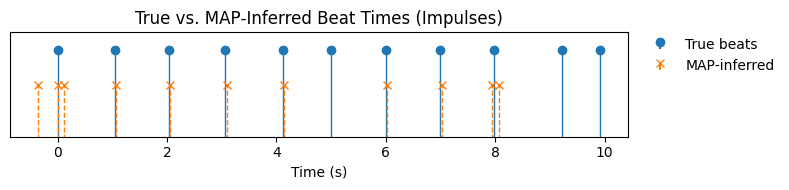

In [16]:
# Reconstruct true & MAP beat times as before
t_true = np.concatenate([[0.0], np.cumsum(z_intervals)])
z_map   = Z_samps[map_idx]
t_map   = np.concatenate([[0.0], np.cumsum(z_map)])

fig, ax = plt.subplots(figsize=(8,2))

# True beats (blue circles + solid stems)
markerline, stemlines, _ = ax.stem(
    t_true, np.ones_like(t_true),
    linefmt='C0-', markerfmt='C0o', basefmt=' ',
    label='True beats'
)
plt.setp(stemlines, 'linewidth', 1)

# MAP‐inferred beats (orange crosses + dashed stems)
markerline2, stemlines2, _ = ax.stem(
    t_map, 0.8*np.ones_like(t_map),
    linefmt='C1--', markerfmt='C1x', basefmt=' ',
    label='MAP‐inferred'
)
plt.setp(stemlines2, 'linewidth', 1)

ax.set_ylim(0.5, 1.1)
ax.set_xlabel("Time (s)")
ax.set_yticks([])   # hide y‐axis ticks
ax.set_title("True vs. MAP‐Inferred Beat Times (Impulses)")

# Place the legend *outside* the plot on the right
ax.legend(
    bbox_to_anchor=(1.02, 1.0),
    loc='upper left',
    borderaxespad=0,
    frameon=False
)

plt.tight_layout()
plt.show()
